In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = './../data/raw/accepted_2007_to_2018Q4.csv'

df = pd.read_csv(data_path, low_memory=False)

print(f"Shape: {df.shape}")
print(f"\nColumns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")

Shape: (2260701, 151)

Columns: 151
Rows: 2260701


In [3]:
print(df.head(3))
print("\n" + "="*80 + "\n")
print("All column names:")
print(df.columns.tolist())

         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_

In [4]:
print("Loan status value counts:")
print(df['loan_status'].value_counts())

Loan status value counts:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [5]:
print("Issue date - first 10 unique values:")
print(df['issue_d'].unique()[:10])

print("\nIssue date value counts (first 20):")
print(df['issue_d'].value_counts().sort_index().head(20))

Issue date - first 10 unique values:
['Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015'
 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015']

Issue date value counts (first 20):
issue_d
Apr-2008      259
Apr-2009      333
Apr-2010      912
Apr-2011     1563
Apr-2012     3230
Apr-2013     9419
Apr-2014    19071
Apr-2015    35427
Apr-2016    36432
Apr-2017    29683
Apr-2018    42928
Aug-2007       74
Aug-2008      100
Aug-2009      446
Aug-2010     1175
Aug-2011     1934
Aug-2012     5419
Aug-2013    12674
Aug-2014    18814
Aug-2015    35886
Name: count, dtype: int64


In [6]:
df['issue_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['issue_year'] = df['issue_date'].dt.year

print("Loans per year:")
print(df['issue_year'].value_counts().sort_index())

Loans per year:
issue_year
2007.0       603
2008.0      2393
2009.0      5281
2010.0     12537
2011.0     21721
2012.0     53367
2013.0    134814
2014.0    235629
2015.0    421095
2016.0    434407
2017.0    443579
2018.0    495242
Name: count, dtype: int64


In [7]:
df_working = df[df['issue_year'].isin([2015, 2016, 2017, 2018])].copy()

print(f"Total loans 2015-2018: {len(df_working)}")
print(f"\nLoan status distribution:")
print(df_working['loan_status'].value_counts())

Total loans 2015-2018: 1794323

Loan status distribution:
loan_status
Current               866392
Fully Paid            702191
Charged Off           192060
Late (31-120 days)     21130
In Grace Period         8235
Late (16-30 days)       4276
Default                   39
Name: count, dtype: int64


In [8]:
statuses_to_keep = ['Fully Paid', 'Charged Off', 'Default']
df_final = df_working[df_working['loan_status'].isin(statuses_to_keep)].copy()

print(f"Loans after filtering: {len(df_final)}")

df_final['default'] = 0
df_final.loc[df_final['loan_status'].isin(['Charged Off', 'Default']), 'default'] = 1

print(f"\nDefault rate: {df_final['default'].mean():.2%}")
print(f"\nDefaults per year:")
print(df_final.groupby('issue_year')['default'].agg(['sum', 'mean']))

Loans after filtering: 894290

Default rate: 21.48%

Defaults per year:
              sum      mean
issue_year                 
2015.0      75804  0.201850
2016.0      68252  0.232859
2017.0      39169  0.231330
2018.0       8874  0.157570


In [9]:
import datetime

cutoff_date = datetime.datetime(2018, 12, 31)

df_final['months_since_issue'] = (cutoff_date - df_final['issue_date']).dt.days / 30

print("2018 loans - months since issue:")
print(df_final[df_final['issue_year'] == 2018]['months_since_issue'].describe())

print("\n2018 loans by month:")
print(df_final[df_final['issue_year'] == 2018].groupby(df_final[df_final['issue_year'] == 2018]['issue_date'].dt.month)['default'].agg(['count', 'mean']))

2018 loans - months since issue:
count    56318.000000
mean         8.335044
std          3.007883
min          1.000000
25%          6.100000
50%          9.133333
75%         11.100000
max         12.133333
Name: months_since_issue, dtype: float64

2018 loans by month:
            count      mean
issue_date                 
1            8600  0.194651
2            6752  0.194905
3            7178  0.194622
4            6924  0.196707
5            6632  0.181393
6            4893  0.159820
7            4317  0.122770
8            3569  0.088260
9            2423  0.071399
10           2150  0.039535
11           1632  0.014706
12           1248  0.010417


In [10]:
df_model = df_final[df_final['issue_year'].isin([2015, 2016, 2017])].copy()

print(f"Final dataset size: {len(df_model)}")
print(f"Default rate: {df_model['default'].mean():.2%}")
print(f"\nDefaults by year:")
print(df_model.groupby('issue_year')['default'].agg(['count', 'sum', 'mean']))

print(f"\nSplit plan:")
print(f"Development (2015-2016): {len(df_model[df_model['issue_year'].isin([2015, 2016])])} loans")
print(f"Validation (2017): {len(df_model[df_model['issue_year'] == 2017])} loans")

Final dataset size: 837972
Default rate: 21.87%

Defaults by year:
             count    sum      mean
issue_year                         
2015.0      375546  75804  0.201850
2016.0      293105  68252  0.232859
2017.0      169321  39169  0.231330

Split plan:
Development (2015-2016): 668651 loans
Validation (2017): 169321 loans


In [11]:
key_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 
                'emp_length', 'home_ownership', 'purpose', 'delinq_2yrs', 
                'inq_last_6mths', 'revol_util', 'term']

print("Missing values in key features:")
for col in key_features:
    missing = df_model[col].isna().sum()
    missing_pct = 100 * missing / len(df_model)
    print(f"{col:20s}: {missing:8d} ({missing_pct:5.2f}%)")

Missing values in key features:
loan_amnt           :        0 ( 0.00%)
int_rate            :        0 ( 0.00%)
annual_inc          :        0 ( 0.00%)
dti                 :      223 ( 0.03%)
fico_range_low      :        0 ( 0.00%)
emp_length          :    53063 ( 6.33%)
home_ownership      :        0 ( 0.00%)
purpose             :        0 ( 0.00%)
delinq_2yrs         :        0 ( 0.00%)
inq_last_6mths      :        1 ( 0.00%)
revol_util          :      493 ( 0.06%)
term                :        0 ( 0.00%)


In [14]:
df_clean = df_model.copy()

n_before = len(df_clean)
df_clean = df_clean[df_clean['annual_inc'] > 0]
df_clean = df_clean[df_clean['annual_inc'] < 10000000]
df_clean = df_clean[df_clean['dti'].notna()]
df_clean = df_clean[df_clean['dti'] >= 0]
df_clean = df_clean[df_clean['dti'] < 100]
df_clean = df_clean[df_clean['revol_util'].notna()]

n_after = len(df_clean)
print(f"Loans before filters: {n_before}")
print(f"Loans after filters: {n_after}")
print(f"Removed: {n_before - n_after} ({100*(n_before-n_after)/n_before:.2f}%)")

print(f"\nFinal default rate: {df_clean['default'].mean():.2%}")

df_clean.to_csv('./../data/processed/loans_clean_2015_2017.csv', index=False)
print("\nSaved to: ./../data/processed/loans_clean_2015_2017.csv")

Loans before filters: 837972
Loans after filters: 836881
Removed: 1091 (0.13%)

Final default rate: 21.86%

Saved to: ./../data/processed/loans_clean_2015_2017.csv


In [15]:
df = pd.read_csv('./../data/processed/loans_clean_2015_2017.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['default'].value_counts())

print("\n" + "="*60)
print("NUMERICAL FEATURES - Basic stats")
print("="*60)

numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 
                  'fico_range_low', 'delinq_2yrs', 'inq_last_6mths', 'revol_util']

for col in numerical_cols:
    print(f"\n{col}:")
    print(df[col].describe())

/var/folders/jb/75f23l_90l313qkrjvrbqjbr0000gn/T/ipykernel_86086/770352110.py:1: DtypeWarning: Columns (19,49,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./../data/processed/loans_clean_2015_2017.csv')


Dataset shape: (836881, 155)

Target distribution:
default
0    653919
1    182962
Name: count, dtype: int64

NUMERICAL FEATURES - Basic stats

loan_amnt:
count    836881.000000
mean      14510.002288
std        8849.172140
min        1000.000000
25%        7800.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

int_rate:
count    836881.000000
mean         12.937480
std           4.891324
min           5.320000
25%           9.170000
50%          12.290000
75%          15.610000
max          30.990000
Name: int_rate, dtype: float64

annual_inc:
count    8.368810e+05
mean     7.771562e+04
std      7.529913e+04
min      6.000000e+02
25%      4.700000e+04
50%      6.500000e+04
75%      9.250000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

dti:
count    836881.000000
mean         18.757369
std           8.895850
min           0.000000
25%          12.180000
50%          18.150000
75%          24.840000
max          9

In [16]:
print("DEFAULT RATE BY FEATURE BINS")
print("="*60)

df['fico_bin'] = pd.cut(df['fico_range_low'], bins=[0, 660, 680, 700, 720, 850])
print("\nFICO Score:")
print(df.groupby('fico_bin')['default'].agg(['count', 'mean']))

df['dti_bin'] = pd.cut(df['dti'], bins=[0, 10, 15, 20, 25, 30, 100])
print("\nDTI Ratio:")
print(df.groupby('dti_bin')['default'].agg(['count', 'mean']))

df['int_rate_bin'] = pd.cut(df['int_rate'], bins=[0, 8, 10, 12, 15, 20, 35])
print("\nInterest Rate:")
print(df.groupby('int_rate_bin')['default'].agg(['count', 'mean']))

df['loan_amnt_bin'] = pd.cut(df['loan_amnt'], bins=[0, 10000, 15000, 20000, 50000])
print("\nLoan Amount:")
print(df.groupby('loan_amnt_bin')['default'].agg(['count', 'mean']))

print("\nDelinquencies (last 2 years):")
print(df.groupby('delinq_2yrs')['default'].mean().head(10))

DEFAULT RATE BY FEATURE BINS

FICO Score:
             count      mean
fico_bin                    
(0, 660]     80754  0.288308
(660, 680]  282294  0.264646
(680, 700]  201439  0.222464
(700, 720]  132192  0.177734
(720, 850]  140202  0.118857

DTI Ratio:
            count      mean
dti_bin                    
(0, 10]    143047  0.161905
(10, 15]   163564  0.180247
(15, 20]   175570  0.205793
(20, 25]   149482  0.234764
(25, 30]   110115  0.268265
(30, 100]   94796  0.311184

Interest Rate:
               count      mean
int_rate_bin                  
(0, 8]        143296  0.062528
(8, 10]       120223  0.121458
(10, 12]      140427  0.172958
(12, 15]      200203  0.239926
(15, 20]      171277  0.342083
(20, 35]       61455  0.463542

Loan Amount:
                 count      mean
loan_amnt_bin                   
(0, 10000]      346351  0.183020
(10000, 15000]  173965  0.230144
(15000, 20000]  130975  0.249697
(20000, 50000]  185590  0.252341

Delinquencies (last 2 years):
delinq_2yrs


/var/folders/jb/75f23l_90l313qkrjvrbqjbr0000gn/T/ipykernel_86086/2112841903.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('fico_bin')['default'].agg(['count', 'mean']))
/var/folders/jb/75f23l_90l313qkrjvrbqjbr0000gn/T/ipykernel_86086/2112841903.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('dti_bin')['default'].agg(['count', 'mean']))
/var/folders/jb/75f23l_90l313qkrjvrbqjbr0000gn/T/ipykernel_86086/2112841903.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

In [17]:
print("CATEGORICAL FEATURES")
print("="*60)

cat_cols = ['term', 'grade', 'home_ownership', 'purpose', 'emp_length']

for col in cat_cols:
    print(f"\n{col}:")
    result = df.groupby(col)['default'].agg(['count', 'mean']).sort_values('mean', ascending=False)
    print(result.head(10))

CATEGORICAL FEATURES

term:
            count      mean
term                       
60 months  193721  0.356895
36 months  643160  0.176976

grade:
        count      mean
grade                  
G        5996  0.541194
F       18882  0.512022
E       57195  0.425632
D      118540  0.340079
C      245954  0.245550
B      242673  0.146815
A      147641  0.063465

home_ownership:
                 count      mean
home_ownership                  
RENT            330678  0.257519
OWN              96855  0.222270
ANY                261  0.203065
MORTGAGE        409085  0.186330
NONE                 2  0.000000

purpose:
                     count      mean
purpose                             
small_business        8085  0.323686
renewable_energy       551  0.270417
moving                6046  0.252398
house                 4049  0.248950
medical              10022  0.236081
debt_consolidation  485829  0.231569
other                49474  0.225654
major_purchase       18056  0.209404
vacation

In [18]:
df_train = df[df['issue_year'].isin([2015, 2016])].copy()
df_valid = df[df['issue_year'] == 2017].copy()

print(f"Training set (2015-2016): {len(df_train)} loans, {df_train['default'].mean():.2%} default")
print(f"Validation set (2017): {len(df_valid)} loans, {df_valid['default'].mean():.2%} default")

df_train.to_csv('./../data/processed/train_2015_2016.csv', index=False)
df_valid.to_csv('./../data/processed/valid_2017.csv', index=False)

print("\nSaved splits.")

Training set (2015-2016): 668182 loans, 21.54% default
Validation set (2017): 168699 loans, 23.12% default

Saved splits.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig_dir = './../figures/'
import os
os.makedirs(fig_dir, exist_ok=True)

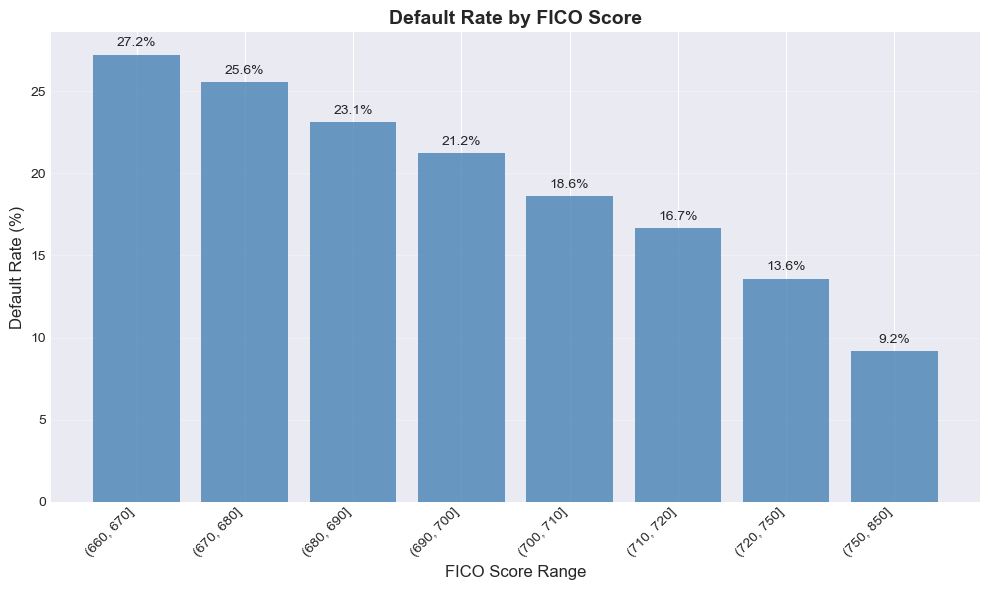

Plot saved: default_by_fico.png


In [20]:
fico_bins = [660, 670, 680, 690, 700, 710, 720, 750, 850]
df['fico_bin_plot'] = pd.cut(df['fico_range_low'], bins=fico_bins)

fico_stats = df.groupby('fico_bin_plot', observed=False)['default'].agg(['mean', 'count'])
fico_stats['default_rate'] = fico_stats['mean'] * 100

fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(fico_stats))
ax.bar(x_pos, fico_stats['default_rate'], color='steelblue', alpha=0.8)

ax.set_xlabel('FICO Score Range', fontsize=12)
ax.set_ylabel('Default Rate (%)', fontsize=12)
ax.set_title('Default Rate by FICO Score', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(fico_stats.index.astype(str), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(fico_stats['default_rate']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(fig_dir + 'default_by_fico.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: default_by_fico.png")

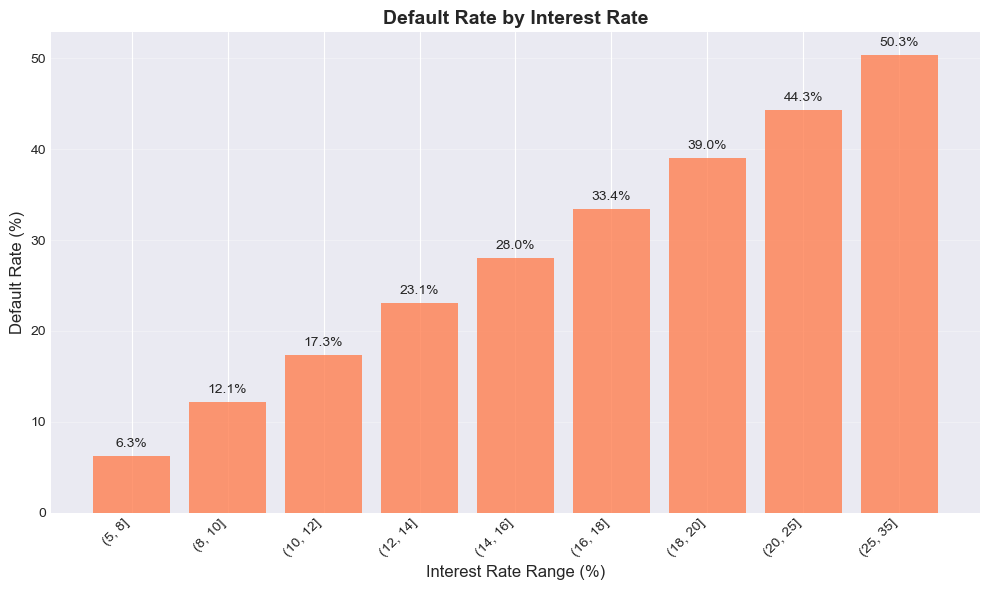

Plot saved: default_by_interest_rate.png


In [21]:
int_rate_bins = [5, 8, 10, 12, 14, 16, 18, 20, 25, 35]
df['int_rate_bin_plot'] = pd.cut(df['int_rate'], bins=int_rate_bins)

int_stats = df.groupby('int_rate_bin_plot', observed=False)['default'].agg(['mean', 'count'])
int_stats['default_rate'] = int_stats['mean'] * 100

fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(int_stats))
ax.bar(x_pos, int_stats['default_rate'], color='coral', alpha=0.8)

ax.set_xlabel('Interest Rate Range (%)', fontsize=12)
ax.set_ylabel('Default Rate (%)', fontsize=12)
ax.set_title('Default Rate by Interest Rate', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(int_stats.index.astype(str), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(int_stats['default_rate']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(fig_dir + 'default_by_interest_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: default_by_interest_rate.png")

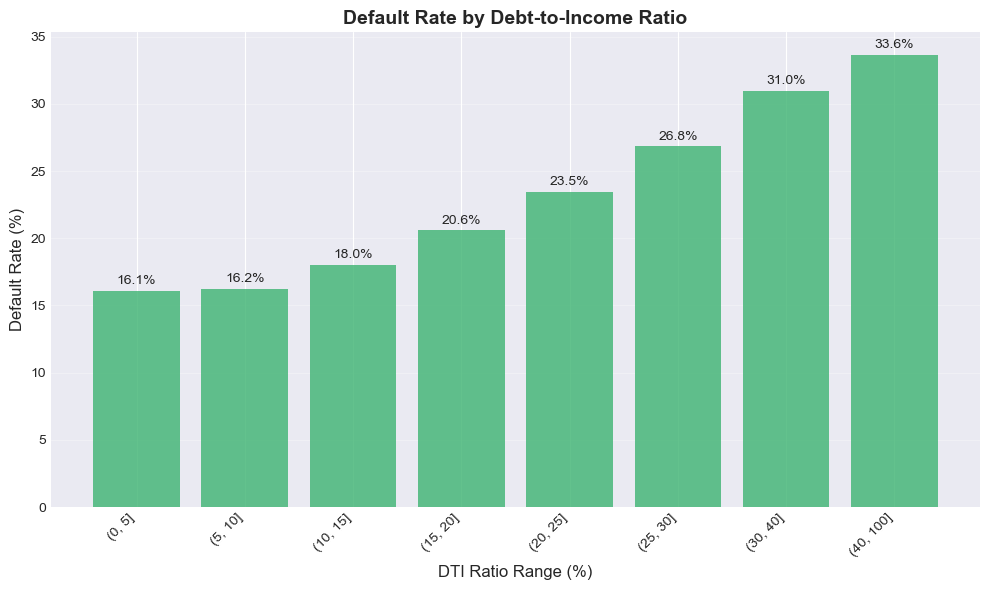

Plot saved: default_by_dti.png


In [22]:
dti_bins = [0, 5, 10, 15, 20, 25, 30, 40, 100]
df['dti_bin_plot'] = pd.cut(df['dti'], bins=dti_bins)

dti_stats = df.groupby('dti_bin_plot', observed=False)['default'].agg(['mean', 'count'])
dti_stats['default_rate'] = dti_stats['mean'] * 100

fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(dti_stats))
ax.bar(x_pos, dti_stats['default_rate'], color='mediumseagreen', alpha=0.8)

ax.set_xlabel('DTI Ratio Range (%)', fontsize=12)
ax.set_ylabel('Default Rate (%)', fontsize=12)
ax.set_title('Default Rate by Debt-to-Income Ratio', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(dti_stats.index.astype(str), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(dti_stats['default_rate']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(fig_dir + 'default_by_dti.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: default_by_dti.png")

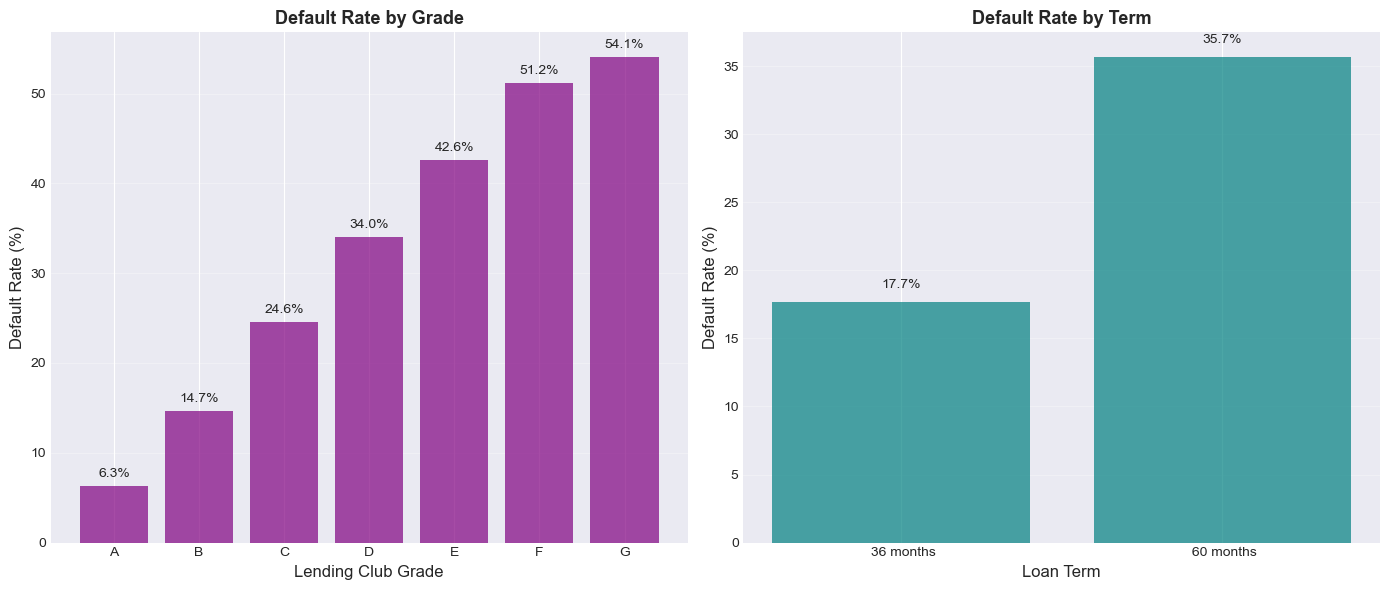

Plot saved: default_by_grade_term.png


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

grade_stats = df.groupby('grade')['default'].agg(['mean', 'count'])
grade_stats['default_rate'] = grade_stats['mean'] * 100
grade_stats = grade_stats.sort_index()

axes[0].bar(range(len(grade_stats)), grade_stats['default_rate'], color='purple', alpha=0.7)
axes[0].set_xlabel('Lending Club Grade', fontsize=12)
axes[0].set_ylabel('Default Rate (%)', fontsize=12)
axes[0].set_title('Default Rate by Grade', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(len(grade_stats)))
axes[0].set_xticklabels(grade_stats.index)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(grade_stats['default_rate']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

term_stats = df.groupby('term')['default'].agg(['mean', 'count'])
term_stats['default_rate'] = term_stats['mean'] * 100

axes[1].bar(range(len(term_stats)), term_stats['default_rate'], color='teal', alpha=0.7)
axes[1].set_xlabel('Loan Term', fontsize=12)
axes[1].set_ylabel('Default Rate (%)', fontsize=12)
axes[1].set_title('Default Rate by Term', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(term_stats)))
axes[1].set_xticklabels(term_stats.index)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(term_stats['default_rate']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(fig_dir + 'default_by_grade_term.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: default_by_grade_term.png")

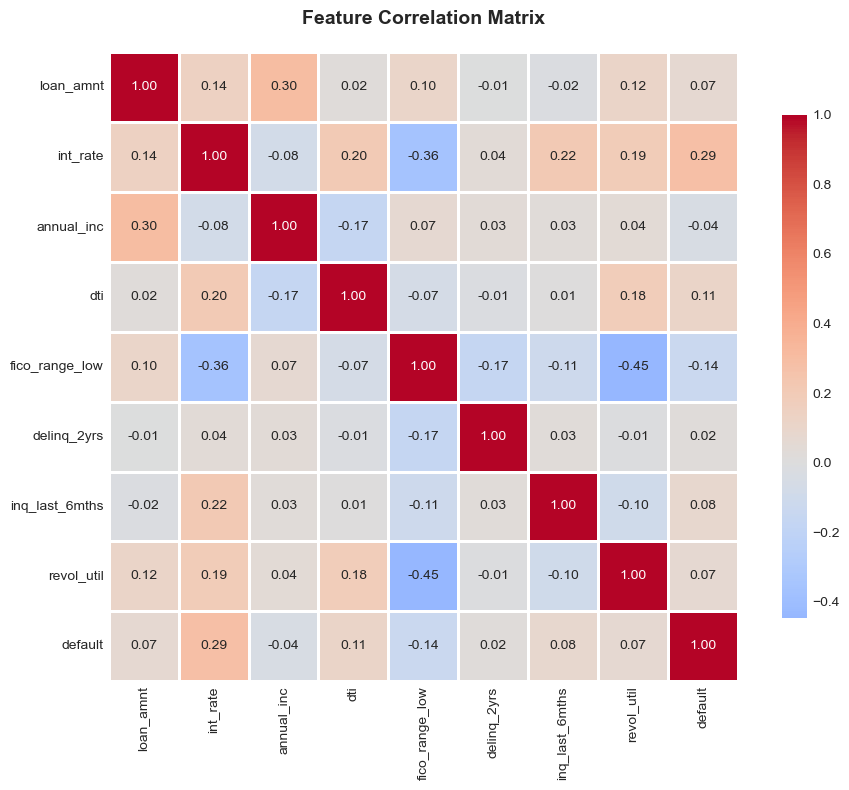

Plot saved: correlation_heatmap.png


In [24]:
numerical_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
                      'delinq_2yrs', 'inq_last_6mths', 'revol_util', 'default']

corr_matrix = df[numerical_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(fig_dir + 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: correlation_heatmap.png")